In [56]:
import os
from typing import List
import random
import glob
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

In [47]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(device)

cpu


In [4]:
"""
Reading data from a csv file and writing to a dataframe.
"""
df: pd.DataFrame = pd.read_csv('Annotasion2.csv', usecols=["Absolute path", "Class name"])
df: pd.DataFrame = df.rename(columns={'Absolute path': 'absPath',
               'Class name': 'className'})

In [5]:
"""
Dividing the dataset into training, test and validation samples.
"""
probs = np.random.rand(len(df))
training_mask = probs < 0.8
test_mask = (probs>=0.8) & (probs < 0.9)
validatoin_mask = probs >= 0.9

df_training = df[training_mask]
df_test = df[test_mask]
df_validation = df[validatoin_mask]

print(df_training)
print(df_test)
print(df_validation)

                                              absPath className
1      C:\Users\nasty\ap_laba2\dataset2\rose_0001.jpg      rose
2      C:\Users\nasty\ap_laba2\dataset2\rose_0002.jpg      rose
3      C:\Users\nasty\ap_laba2\dataset2\rose_0003.jpg      rose
4      C:\Users\nasty\ap_laba2\dataset2\rose_0004.jpg      rose
5      C:\Users\nasty\ap_laba2\dataset2\rose_0005.jpg      rose
...                                               ...       ...
1996  C:\Users\nasty\ap_laba2\dataset2\tulip_0995.jpg     tulip
1997  C:\Users\nasty\ap_laba2\dataset2\tulip_0996.jpg     tulip
1998  C:\Users\nasty\ap_laba2\dataset2\tulip_0997.jpg     tulip
1999  C:\Users\nasty\ap_laba2\dataset2\tulip_0998.jpg     tulip
2001  C:\Users\nasty\ap_laba2\dataset2\tulip_1000.jpg     tulip

[1583 rows x 2 columns]
                                              absPath className
0      C:\Users\nasty\ap_laba2\dataset2\rose_0000.jpg      rose
11     C:\Users\nasty\ap_laba2\dataset2\rose_0011.jpg      rose
21     C:\Users

In [6]:
"""
Declaring paths and creating folders.
"""
train_path='C:/Users/nasty/ap_laba5new/train2'
test_path='C:/Users/nasty/ap_laba5new/test2'
val_path='C:/Users/nasty/ap_laba5new/val2'

if not os.path.isdir(train_path):
    os.mkdir(train_path)

if not os.path.isdir(test_path):
    os.mkdir(test_path)
    
if not os.path.isdir(val_path):
    os.mkdir(val_path)

In [7]:
"""
Copying selections to the appropriate folders and renaming them
"""
i = 0
for path in df_training["absPath"]:
    class_name = path.split('\\')[-1].split('.')[0].split('_')[0]
    image = cv2.imread(path)
    cv2.imwrite(os.path.join(train_path, f'{class_name}.{i}.jpg'), image)
    i+=1

for path in df_test["absPath"]:
    image = cv2.imread(path)
    cv2.imwrite(os.path.join(test_path, f'{i}.jpg'), image)
    i+=1

for path in df_validation["absPath"]:
    class_name = path.split('\\')[-1].split('.')[0].split('_')[0]
    image = cv2.imread(path)
    cv2.imwrite(os.path.join(val_path, f'{class_name}.{i}.jpg'), image)
    i+=1

In [8]:
"""
Getting a new list of image paths.
"""
train_list: List[str] = glob.glob(os.path.join(train_path,'*.jpg'))
test_list: List[str] = glob.glob(os.path.join(test_path, '*.jpg'))
val_list: List[str] = glob.glob(os.path.join(val_path,'*.jpg'))

['C:/Users/nasty/ap_laba5new/train2\\rose.0.jpg', 'C:/Users/nasty/ap_laba5new/train2\\rose.1.jpg', 'C:/Users/nasty/ap_laba5new/train2\\rose.10.jpg', 'C:/Users/nasty/ap_laba5new/train2\\rose.100.jpg', 'C:/Users/nasty/ap_laba5new/train2\\rose.101.jpg', 'C:/Users/nasty/ap_laba5new/train2\\rose.102.jpg', 'C:/Users/nasty/ap_laba5new/train2\\rose.103.jpg', 'C:/Users/nasty/ap_laba5new/train2\\rose.104.jpg', 'C:/Users/nasty/ap_laba5new/train2\\rose.105.jpg', 'C:/Users/nasty/ap_laba5new/train2\\rose.106.jpg', 'C:/Users/nasty/ap_laba5new/train2\\rose.107.jpg', 'C:/Users/nasty/ap_laba5new/train2\\rose.108.jpg', 'C:/Users/nasty/ap_laba5new/train2\\rose.109.jpg', 'C:/Users/nasty/ap_laba5new/train2\\rose.11.jpg', 'C:/Users/nasty/ap_laba5new/train2\\rose.110.jpg', 'C:/Users/nasty/ap_laba5new/train2\\rose.111.jpg', 'C:/Users/nasty/ap_laba5new/train2\\rose.112.jpg', 'C:/Users/nasty/ap_laba5new/train2\\rose.113.jpg', 'C:/Users/nasty/ap_laba5new/train2\\rose.114.jpg', 'C:/Users/nasty/ap_laba5new/train2\\

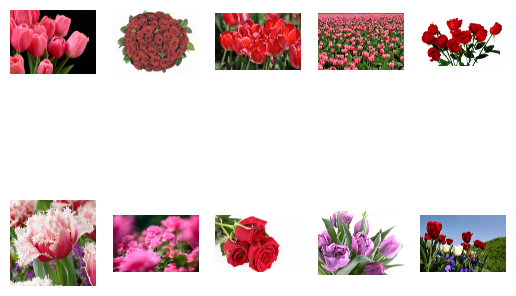

In [57]:
"""
Checking for balance.
"""
random_idx = np.random.randint(1,len(train_list),size=10)

fig = plt.figure()
i=1
for idx in random_idx:
    ax = fig.add_subplot(2,5,i)
    img = Image.open(train_list[idx])
    plt.imshow(img)
    i+=1
    plt.axis('off')


plt.show()

In [39]:
class dataset(torch.utils.data.Dataset):
    """ 
    Creating a child class 'dataset'
    """
    def __init__(self,file_list,transform=None):
        """ 
        Initialization of the class. It accepts a list of image paths and a transformation method as input.
        """
        self.file_list = file_list
        self.transform = transform
   
    def __len__(self):
        """ 
        Getting the length of the list.
        """
        self.filelength = len(self.file_list)
        return self.filelength
    
    def __getitem__(self,idx):
        """ 
        Getting an image. accepts an index as input and returns an image based on this index and its label.
        """
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        
        label = img_path.split('\\')[-1].split('.')[0]
        if label == 'tulip':
            label=1
        elif label == 'rose':
            label=0
            
        return img_transformed,label

In [40]:
""" 
Image transformation functions for each sample: cropping, setting to a horizontal position and converting to a tensor.
"""
train_transforms =  transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])

val_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])

test_transforms = transforms.Compose([   
    transforms.Resize((224, 224)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
    ])

In [ ]:
""" 
Creating a dataset for each sample.
"""
train_data = dataset(train_list, transform=train_transforms)
test_data = dataset(test_list, transform=test_transforms)
val_data = dataset(val_list, transform=val_transforms)

In [41]:
class CNN(nn.Module):
    """ 
    Designing a convolutional neural network.
    """
    def __init__(self):
        """ 
        Initializing a class.
        Setting model parameters in layers.
        """
        super(CNN,self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=3, padding=0,stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(16,32, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
            )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(32,64, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(3*3*64,10)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(10,2)
        self.relu = nn.ReLU()
        
        
    def forward(self,x):
        """ 
        The method builds a network architecture (layers are linked into a computational graph).
        """
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0),-1)
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        return out

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=576, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=10, out_features=2, bias=True)
 

In [ ]:
model = CNN().to(device)
model.train()

Learning rate: 0.001, Batch size: 64


Epoch : 1, train accuracy : 0.7015558481216431, train loss : 0.5570324659347534
Epoch : 1, val_accuracy : 0.6953125, val_loss : 0.5400792956352234
Epoch : 2, train accuracy : 0.7857445478439331, train loss : 0.446934312582016
Epoch : 2, val_accuracy : 0.71484375, val_loss : 0.5959600210189819
Epoch : 3, train accuracy : 0.798816442489624, train loss : 0.42346668243408203
Epoch : 3, val_accuracy : 0.85546875, val_loss : 0.330893874168396
Epoch : 4, train accuracy : 0.8064892888069153, train loss : 0.40859347581863403
Epoch : 4, val_accuracy : 0.859375, val_loss : 0.3838239312171936
Epoch : 5, train accuracy : 0.8411437273025513, train loss : 0.35279983282089233
Epoch : 5, val_accuracy : 0.7734375, val_loss : 0.4464273154735565
Epoch : 6, train accuracy : 0.8417154550552368, train loss : 0.3457339107990265
Epoch : 6, val_accuracy : 0.64453125, val_loss : 0.8415014743804932
Epoch : 7, train accuracy : 0.8465425372123718, train loss : 0.3436155617237091
Epoch : 7, val_accuracy : 0.88671875

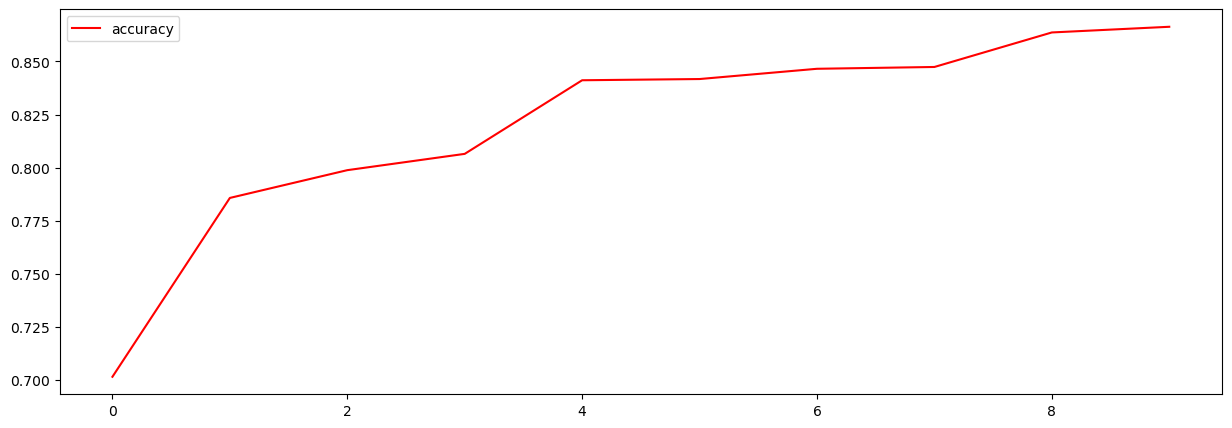

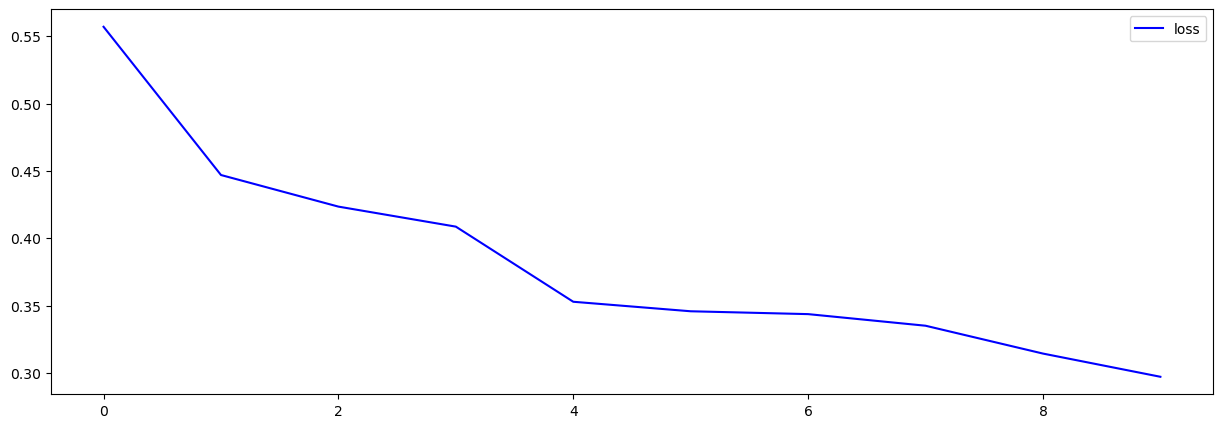

The graph for the validation sample


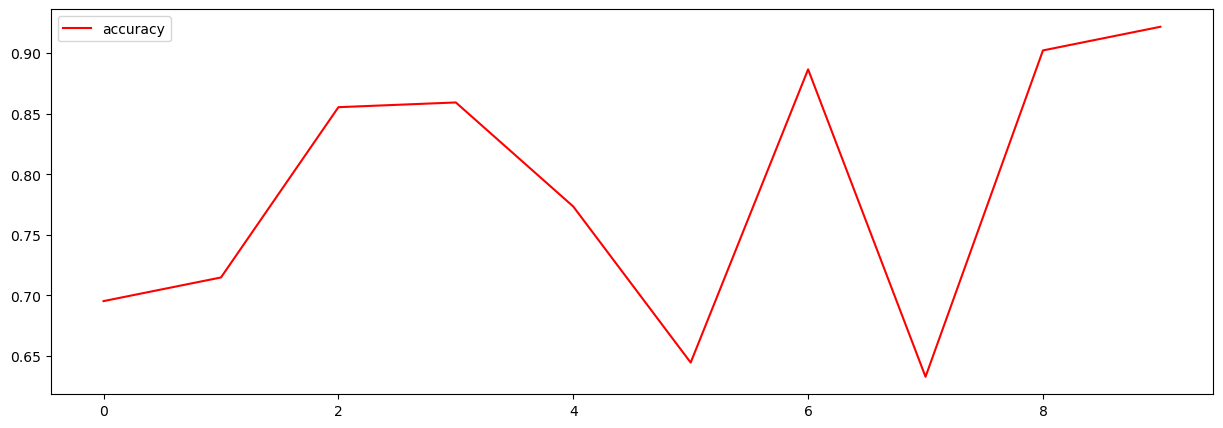

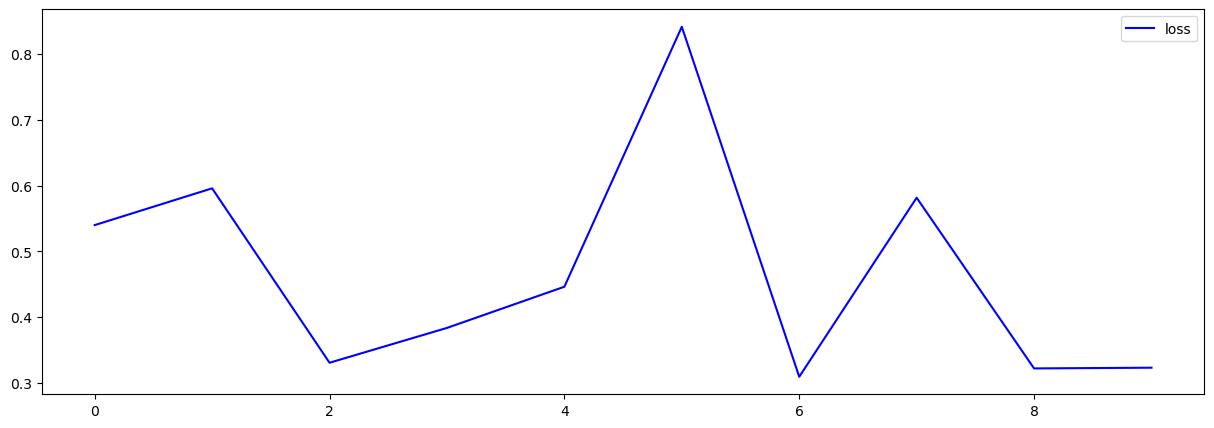

In [42]:
print('Learning rate: 0.001, Batch size: 64')

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=64, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=64, shuffle=True)

epochs = 10
def train_loop (train_loader, val_loader, epochs):
    val_loss_list = []
    val_accuracy_list = []

    loss_list = []
    accuracy_list = []

    for epoch in range(epochs):
        epoch_loss = 0
        epoch_accuracy = 0
        for data, label in train_loader:
            data = data.to(device)
            label = label.to(device)

            output = model(data)
            loss = criterion(output, label)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            acc = ((output.argmax(dim=1) == label).float().mean())
            epoch_accuracy += acc/len(train_loader)
            epoch_loss += loss/len(train_loader)

        loss_list.append(epoch_loss.item())
        accuracy_list.append(epoch_accuracy.item())

        print('Epoch : {}, train accuracy : {}, train loss : {}'.format(epoch+1, epoch_accuracy,epoch_loss))


        with torch.no_grad():
            epoch_val_accuracy=0
            epoch_val_loss =0
            
            for data, label in val_loader:
                data = data.to(device)
                label = label.to(device)

                val_output = model(data)
                val_loss = criterion(val_output,label)

                acc = ((val_output.argmax(dim=1) == label).float().mean())
                epoch_val_accuracy += acc/ len(val_loader)
                epoch_val_loss += val_loss/ len(val_loader)


            val_loss_list.append(epoch_val_loss.item())
            val_accuracy_list.append(epoch_val_accuracy.item())

            print('Epoch : {}, val_accuracy : {}, val_loss : {}'.format(epoch+1, epoch_val_accuracy,epoch_val_loss))


    print("\nThe graph for the training sample")

    plt.figure(figsize=(15, 5))
    plt.plot(range(10), accuracy_list, color="red")
    plt.legend(["accuracy"])
    plt.show()

    plt.figure(figsize=(15, 5))
    plt.plot(range(10), loss_list, color="blue")
    plt.legend(["loss"])
    plt.show() 

    print("The graph for the validation sample")

    plt.figure(figsize=(15, 5))
    plt.plot(range(10), val_accuracy_list, color="red")
    plt.legend(["accuracy"])
    plt.show()

    plt.figure(figsize=(15, 5))
    plt.plot(range(10), val_loss_list, color="blue")
    plt.legend(["loss"])
    plt.show() 

train_loop(train_loader, val_loader, epochs)

In [53]:
rose_probs = []
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        preds = model(images)
        preds_list = F.softmax(preds, dim=1)[:, 1].tolist()
        rose_probs += list(zip(labels, preds_list))

rose_probs.sort(key = lambda x : int(x[0]))     
idx = list(map(lambda x: x[0],rose_probs))
prob = list(map(lambda x: x[1],rose_probs))

submission = pd.DataFrame({'id':idx,'label':prob})

submission

,id,label
0,1583,0.475561
1,1584,0.046911
2,1585,0.009369
3,1586,0.225874
4,1587,0.072200
...,...,...
220,1803,0.476242
221,1804,0.238075
222,1805,0.986394
223,1806,0.059657


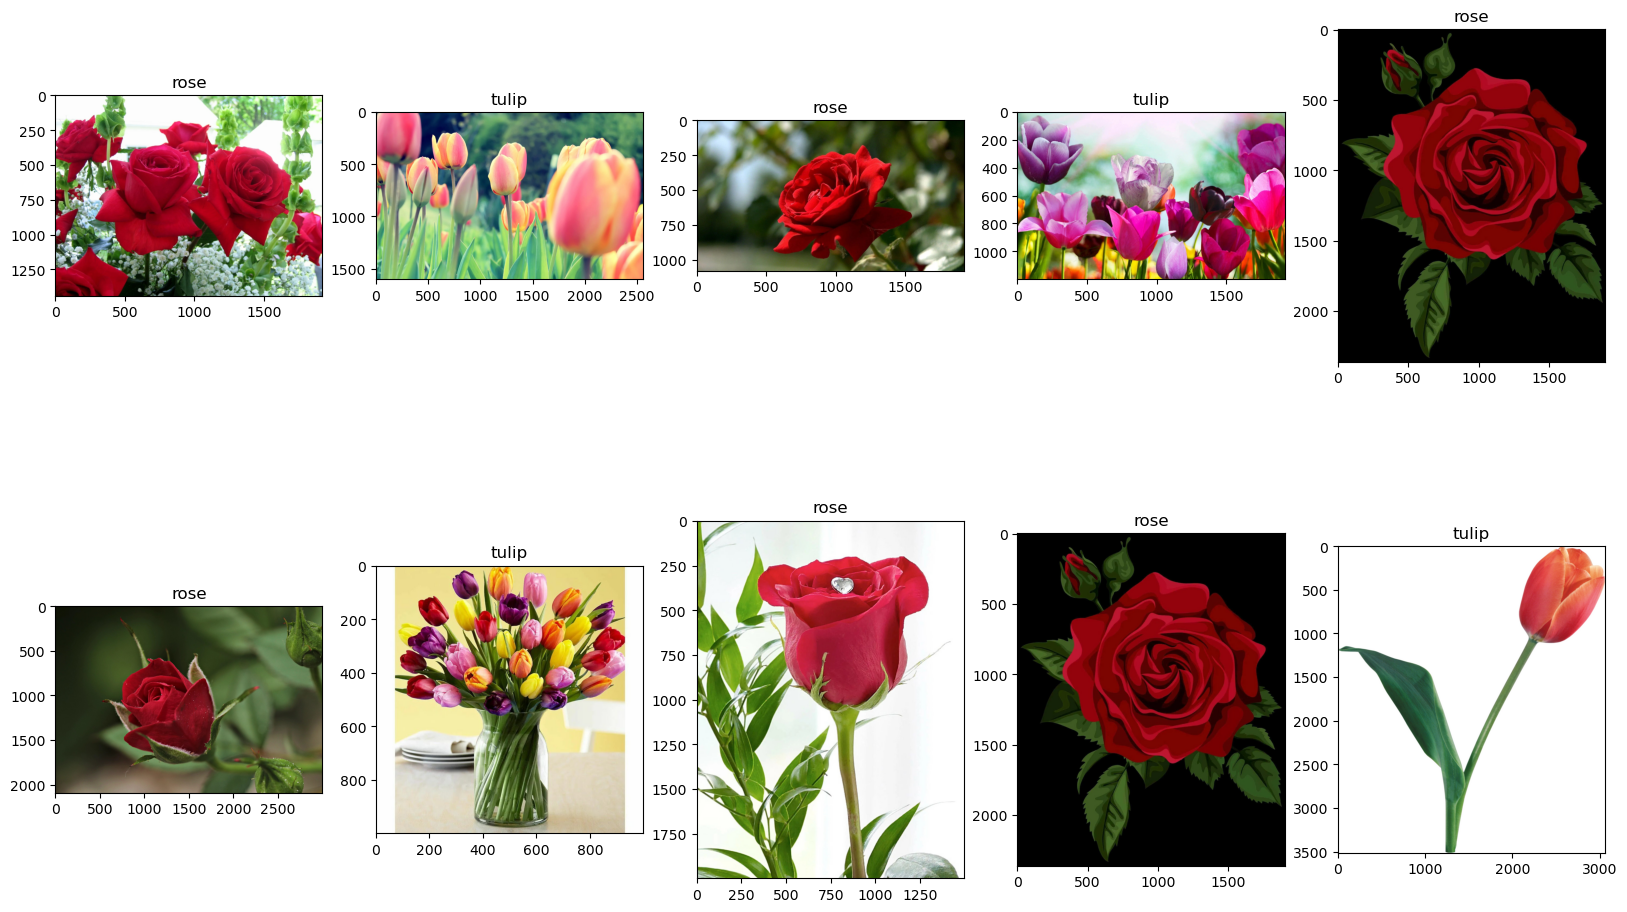

In [54]:
class_ = {0: 'rose', 1: 'tulip'}

fig, axes = plt.subplots(2, 5, figsize=(20, 12), facecolor='w')

for ax in axes.ravel():
    
    i = random.choice(submission['id'].values)
    
    label = submission.loc[submission['id'] == i, 'label'].values[0]
    if label > 0.5:
        label = 1
    else:
        label = 0
        
    img_path = os.path.join(test_path, '{}.jpg'.format(i))
    img = Image.open(img_path)
    
    ax.set_title(class_[label])
    ax.imshow(img)

In [ ]:
""" 
Saving the model.
"""
torch.save(model.state_dict(), 'CNNmodel.pt')

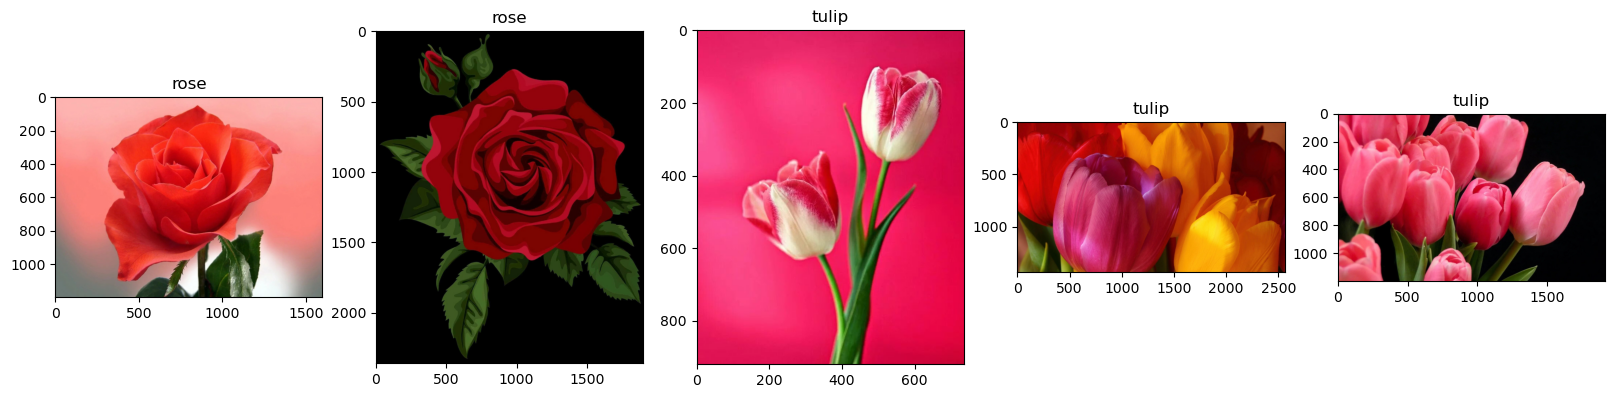

In [55]:
loaded_model = CNN()
loaded_model.load_state_dict(torch.load('CNNmodel.pt'))
loaded_model.to(device)

tulip_probs = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        preds = loaded_model(images)
        preds_list = F.softmax(preds, dim=1)[:, 1].tolist()
        tulip_probs += list(zip(labels, preds_list))
        
idx = list(map(lambda x: x[0],tulip_probs))
prob = list(map(lambda x: x[1],tulip_probs))

submission = pd.DataFrame({'id':idx,'label':prob})

class_ = {0: 'rose', 1: 'tulip'}

fig, axes = plt.subplots(1, 5, figsize=(20, 12), facecolor='w')

for ax in axes.ravel():
    
    i = random.choice(submission['id'].values)
    
    label = submission.loc[submission['id'] == i, 'label'].values[0]
    if label > 0.5:
        label = 1
    else:
        label = 0
        
    img_path = os.path.join(test_path, f'{i}.jpg')
    img = Image.open(img_path)
    
    ax.set_title(class_[label])
    ax.imshow(img)